In [40]:
import pandas as pd
import numpy as np
import os
import glob
import itertools
import nibabel as nib
from typing import Tuple, Dict, List
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

In [41]:
DATA_DIR = "/Users/rushil/brain_extraction//data"
METHOD_DIRS = {
    "Robust-CTBET":   os.path.join(DATA_DIR, "brain_mask"),
    "Brainchop":      os.path.join(DATA_DIR, "brain_mask_brainchop"),
    "Docker_Ctbet":   os.path.join(DATA_DIR, "brain_mask_dockerctbet"),
}
OUT_CSV_RAW   = os.path.join(DATA_DIR, "pairwise_2x2_metrics_all_scans.csv")
OUT_CSV_PAIR  = os.path.join(DATA_DIR, "pairwise_patient_agg_dice.csv")
OUT_CSV_CI    = os.path.join(DATA_DIR, "pairwise_dice_bootstrap_ci.csv")
OUT_CSV_MACRO = os.path.join(DATA_DIR, "macro_avg_dice_per_method.csv")


In [42]:
# ===== helpers for geometry and metrics =====
def stem(p: str) -> str:
    base = os.path.basename(p)
    for suf in (".nii.gz", ".nii"):
        if base.endswith(suf):
            return base[: -len(suf)]
    return base

def patient_id_from_stem(s: str) -> str:
    # e.g., "6506-324_20170906_1752_ct" -> "6506-324"
    return s.split("_")[0]

def load_mask_bool(path: str):
    img = nib.load(path)
    arr = img.get_fdata(dtype=np.float32) > 0  # binarize
    return img, arr

def confusion_2x2(a, b):
    tp = np.count_nonzero(a &  b)
    fp = np.count_nonzero(a & ~b)
    fn = np.count_nonzero(~a &  b)
    tn = np.count_nonzero(~a & ~b)
    return tp, fp, fn, tn

def dice(tp, fp, fn):
    den = 2*tp + fp + fn
    return (2*tp/den) if den else np.nan

def iou(tp, fp, fn):
    den = tp + fp + fn
    return (tp/den) if den else np.nan

def accuracy(tp, fp, fn, tn):
    den = tp+fp+fn+tn
    return (tp+tn)/den if den else np.nan

def sensitivity(tp, fn):
    den = tp+fn
    return tp/den if den else np.nan

def specificity(tn, fp):
    den = tn+fp
    return tn/den if den else np.nan

def kappa(tp, fp, fn, tn):
    n = tp+fp+fn+tn
    if n == 0: return np.nan
    po = (tp+tn)/n
    pe = ((tp+fp)/n)*((tp+fn)/n) + ((fn+tn)/n)*((fp+tn)/n)
    den = 1 - pe
    return (po - pe)/den if den else np.nan

def bootstrap_ci(vals: np.ndarray, B: int = 2000, alpha: float = 0.05, use_median: bool = True):
    if len(vals) == 0:
        return np.nan, np.nan
    
    stat_fun = np.median if use_median else np.mean
    
    res = bootstrap(
        data=(vals,),               # data as a tuple
        statistic=stat_fun,         # function to apply
        confidence_level=1-alpha,   # e.g. 0.95
        n_resamples=B,
        method="percentile",        # matches your old function
        random_state=0              # reproducible
    )
    return float(res.confidence_interval.low), float(res.confidence_interval.high)

In [43]:
# ===== discover stems and compute per-scan pairwise rows =====
method_files = {m: glob.glob(os.path.join(d, "*.nii*")) for m,d in METHOD_DIRS.items()}
method_maps  = {m: {stem(p): p for p in files} for m,files in method_files.items()}

# stems present in ≥2 methods
all_stems: Dict[str, set] = {}
for m, mp in method_maps.items():
    for s in mp.keys():
        all_stems.setdefault(s, set()).add(m)
candidate_stems = sorted([s for s, ms in all_stems.items() if len(ms) >= 2])


In [44]:
rows = []
for s in candidate_stems:
    imgs, masks = {}, {}
    aff, shape = None, None
    methods_here = sorted(all_stems[s])
    # load and check geometry
    ok = True
    for m in methods_here:
        p = method_maps[m][s]
        img, arr = load_mask_bool(p)
        if shape is None:
            shape, aff = img.shape, img.affine
        else:
            if img.shape != shape or not np.allclose(img.affine, aff, atol=1e-3):
                ok = False; break
        imgs[m], masks[m] = img, arr
    if not ok:
        continue

    pid = patient_id_from_stem(s)
    # pairwise metrics (per scan)
    for A, B in itertools.combinations(methods_here, 2):
        a, b = masks[A], masks[B]
        tp, fp, fn, tn = confusion_2x2(a, b)
        rows.append({
            "patient_id": pid,
            "stem": s,
            "method_A": A, "method_B": B,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn,
            "dice": dice(tp, fp, fn),
            "iou": iou(tp, fp, fn),
            "accuracy": accuracy(tp, fp, fn, tn),
            "sensitivity_A_vs_B": sensitivity(tp, fn),
            "specificity_A_vs_B": specificity(tn, fp),
            "kappa": kappa(tp, fp, fn, tn),
            "n_vox": int(tp+fp+fn+tn)
        })


In [45]:
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV_RAW, index=False)
print(f"[raw] scans: {len(set(df['stem']))}  pairs: {len(df)}  rows saved -> {OUT_CSV_RAW}")
df

KeyError: 'stem'

In [21]:
# ===== patient-level aggregation (per pair) =====
# pick metric to publish in main matrix
METRIC = "dice"          # main metric
AGGR   = "mean"        # or "mean"

# collapse scans -> patient
scan2pat = df.groupby(["patient_id","method_A","method_B"], as_index=False)[METRIC].agg(AGGR)
scan2pat.rename(columns={METRIC: f"{METRIC}_patient"}, inplace=True)
print(scan2pat)
# ===== cohort-level point estimates (per pair) =====
pair_stats = (scan2pat
              .groupby(["method_A","method_B"], as_index=False)[f"{METRIC}_patient"]
              .agg(point = (lambda x: np.median(x) if AGGR=="median" else np.mean(x)),
                   n_patients=("count")))

pair_stats.to_csv(OUT_CSV_PAIR, index=False)
print(f"[patient-agg] saved -> {OUT_CSV_PAIR}")
print(pair_stats)

  patient_id      method_A      method_B  dice_patient
0   6001-161     Brainchop  Docker_Ctbet      0.952520
1   6001-161     Brainchop  Robust-CTBET      0.951091
2   6001-161  Docker_Ctbet  Robust-CTBET      0.995008
3   6002-301     Brainchop  Docker_Ctbet      0.957951
4   6002-301     Brainchop  Robust-CTBET      0.955274
5   6002-301  Docker_Ctbet  Robust-CTBET      0.994717
[patient-agg] saved -> /Users/rushil/brain_extraction//data/pairwise_patient_agg_dice.csv
       method_A      method_B     point  n_patients
0     Brainchop  Docker_Ctbet  0.955235           2
1     Brainchop  Robust-CTBET  0.953182           2
2  Docker_Ctbet  Robust-CTBET  0.994862           2


In [22]:
# ===== patient-level bootstrap CIs (per pair) =====
ci_rows = []
use_median = (AGGR == "median")
for (A, B), g in scan2pat.groupby(["method_A", "method_B"]):
    v = g[f"{METRIC}_patient"].to_numpy()
    if v.size == 0:
        lo = hi = np.nan
        point = np.nan
    else:
        stat_fun = np.median if use_median else np.mean
        res = bootstrap(
            data=(v,),
            statistic=stat_fun,
            confidence_level=0.95,
            n_resamples=2000,
            method="percentile",
            random_state=0,
        )
        lo = float(res.confidence_interval.low)
        hi = float(res.confidence_interval.high)
        point = float(stat_fun(v))

    ci_rows.append({
        "method_A": A, "method_B": B, "metric": METRIC,
        "point": point, "ci_lo": lo, "ci_hi": hi,
        "n_patients": int(v.size)
    })

ci_df = pd.DataFrame(ci_rows)
ci_df.to_csv(OUT_CSV_CI, index=False)
print(f"[bootstrap] saved -> {OUT_CSV_CI}")
ci_df

[bootstrap] saved -> /Users/rushil/brain_extraction//data/pairwise_dice_bootstrap_ci.csv


,method_A,method_B,metric,point,ci_lo,ci_hi,n_patients
0,Brainchop,Docker_Ctbet,dice,0.955235,0.952520,0.957951,2
1,Brainchop,Robust-CTBET,dice,0.953182,0.951091,0.955274,2
2,Docker_Ctbet,Robust-CTBET,dice,0.994862,0.994717,0.995008,2


In [23]:
# ===== optional: 7×7 Dice matrix (point estimates) =====
methods = sorted(set(list(df["method_A"]) + list(df["method_B"])))
mat = pd.DataFrame(np.eye(len(methods)), index=methods, columns=methods, dtype=float)
for _, r in pair_stats.iterrows():
    a, b, v = r["method_A"], r["method_B"], r["point"]
    mat.loc[a,b] = mat.loc[b,a] = v
mat.to_csv(os.path.join(DATA_DIR, "dice_matrix_point.csv"))
mat

,Brainchop,Docker_Ctbet,Robust-CTBET
Brainchop,1.000000,0.955235,0.953182
Docker_Ctbet,0.955235,1.000000,0.994862
Robust-CTBET,0.953182,0.994862,1.000000


In [24]:
# === macro-average Dice per method with 95% CIs (uses your bootstrap_ci) ===
methods = sorted(set(df["method_A"]).union(df["method_B"]))
macro_rows = []

for m in methods:
    # collect patient-level Dice for all pairs involving m
    parts = []
    for (A, B), g in scan2pat.groupby(["method_A", "method_B"]):
        if m in (A, B):
            parts.append(g[["patient_id", f"{METRIC}_patient"]]
                         .rename(columns={f"{METRIC}_patient": "val"}))
    if not parts:
        continue

    merged = pd.concat(parts, axis=0, ignore_index=True)

    # per patient: average across the 6 pairs that include method m
    per_patient = (merged.groupby("patient_id", as_index=False)["val"]
                          .mean())

    v = per_patient["val"].to_numpy()
    v = v[~np.isnan(v)]
    n = v.size

    if n == 0:
        point, lo, hi = np.nan, np.nan, np.nan
    elif n == 1:
        point = float(np.mean(v))
        lo, hi = np.nan, np.nan
    else:
        point = float(np.mean(v))
        lo, hi = bootstrap_ci(v, B=2000, alpha=0.05, use_median=False)  # mean across patients

    macro_rows.append({
        "method": m,
        "macro_avg_dice": point,
        "ci_lo": lo,
        "ci_hi": hi,
        "n_patients": int(n),
    })

macro_df = pd.DataFrame(macro_rows)
macro_df.to_csv(OUT_CSV_MACRO, index=False)
print(f"[macro] saved -> {OUT_CSV_MACRO}")


[macro] saved -> /Users/rushil/brain_extraction//data/macro_avg_dice_per_method.csv


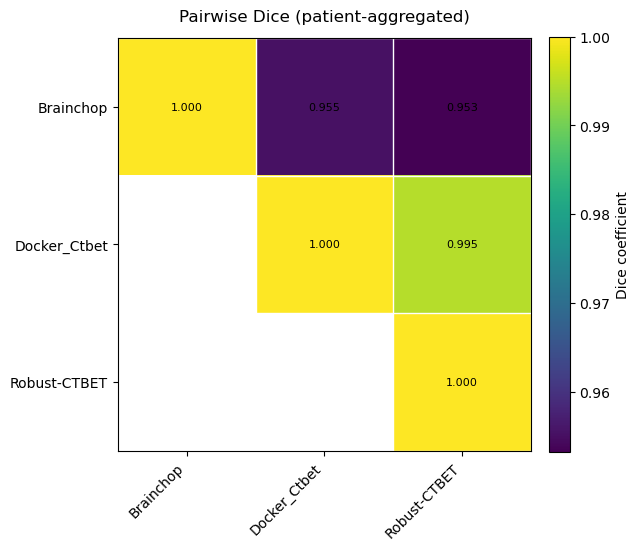

In [ ]:
png_path = "dice_heatmap_masked.png"
pdf_path = "dice_heatmap_masked.pdf"

labels = list(mat.columns)

M = mat.values.astype(float)
np.fill_diagonal(M, 1.0)
M = (M + M.T) / 2.0

mask = np.tri(M.shape[0], k=-1, dtype=bool)
M_masked = np.ma.array(M, mask=mask)

fig, ax = plt.subplots(figsize=(6.5, 6.0))
im = ax.imshow(M_masked, interpolation="nearest")  # default colormap

ax.set_xticks(np.arange(M.shape[1]))
ax.set_yticks(np.arange(M.shape[0]))
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(labels, fontsize=10)

ax.set_xticks(np.arange(-0.5, M.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, M.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if i <= j and not np.isnan(M[i, j]):
            ax.text(j, i, f"{M[i, j]:.3f}", ha="center", va="center", fontsize=8)

ax.set_title("Pairwise Dice (patient-aggregated)", fontsize=12, pad=12)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Dice coefficient", fontsize=10)

ax.set_aspect("equal")
plt.tight_layout()
plt.savefig(png_path, dpi=600, bbox_inches="tight")
plt.savefig(pdf_path, dpi=600, bbox_inches="tight")